# Simulation with box function + RFE + random forest classification + Shapley value analysis

Ver 1, 20210921

For the simulation, we start by randomly drawing n number of SMILES, and check that they are working using t-SNE. After that, we generate the input of the dataset using Mordred featurization, and the output using simple box (rectangular) function (f(x) = 0 for any ATSC5Z -our feature of interest, outside our range of interest).

After building the dataset, we can test the algorithm of the hypothesis generation by testing the recursive feature elimination, random forest classification, and Shapley value analysis, and check if our feature of interest survives through it. If it comes out as important feature, the sequence of algorithms with that particular dataset is working.

**IMPORTANT!!** DON'T FORGET TO GET THE EMOLECULES FILE FROM https://downloads.emolecules.com/free/, and put it in the dataset folder.

This is based on this GitHub: https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb

## Loading dataset

In [98]:
# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import rdkit
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
from IPython.display import display_html
import seaborn as sns

from tqdm import tqdm

In [99]:
# Import the perovskite crystal data
from collections import OrderedDict
cmaps = OrderedDict()

## IMPORTING DATA

# Change directory to where your .csv file is
os.chdir(os.getcwd())

# Load the .csv file 

largeData = pd.read_csv('dataset/version.smi',sep='\s') 

# Check if the data is loaded and separated correctly
pd.set_option('max_rows', 8)

largeData_df = pd.DataFrame(largeData)
selected_largeData_df = largeData_df.sample(n =100) # Select number of samples of your interest
selected_largeData_df 

C:\Users\Titan\Anaconda3\envs\pvkadditives\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,isosmiles,version_id,parent_id
29188367,CCc1ccccc1NC(=O)\C=C\C1CCC1,328152268,328152268
8730561,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,54551429,54551429
21692157,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,320000123,320000123
14954592,CC1OCCC1(C)Nc1nnc(S)s1,266534456,266534456
...,...,...,...
15239590,CC1CN(CCO1)C(CNC(=O)N[C@@H]1COC(=O)C1)c1c(F)cc...,279054875,279054875
31502331,CCC(c1ccc(OC)c(O)c1)n1nc(C(F)F)c(C#N)c1Br,330676217,330676217
20787845,CC(C)C(C(=O)N1Cc2ccccc2C2(CC2)C1)n1cnnc1,318948514,318948514
5287794,CCOC(=O)C(C)CNc1cccc(c1)C#N,38530666,38530666


In [100]:
# Drop other dataset, and add the 'data_collected' to 0, which will label these molecules as unexplored in the t-SNE
largeData_df_dropped = selected_largeData_df.drop(['version_id','parent_id'],axis=1)
largeData_df_dropped['data_collected']=0
largeData_df_dropped

,isosmiles,data_collected
29188367,CCc1ccccc1NC(=O)\C=C\C1CCC1,0
8730561,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,0
21692157,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,0
14954592,CC1OCCC1(C)Nc1nnc(S)s1,0
...,...,...
15239590,CC1CN(CCO1)C(CNC(=O)N[C@@H]1COC(=O)C1)c1c(F)cc...,0
31502331,CCC(c1ccc(OC)c(O)c1)n1nc(C(F)F)c(C#N)c1Br,0
20787845,CC(C)C(C(=O)N1Cc2ccccc2C2(CC2)C1)n1cnnc1,0
5287794,CCOC(=O)C(C)CNc1cccc(c1)C#N,0


In [101]:
smallData= pd.read_csv('dataset/20211013_smiles_experimental_candidates.csv')
smallData_df = pd.DataFrame(smallData)
smallData_df

,isosmiles,data_collected
0,Brc1cccc(n1)-c2cccc(Br)n2,1
1,Brc1cccc(n1)-c2cccc(n2)-c3cccc(Br)n3,3
2,Brc1cccc(n1)-c2ccccn2,1
3,C1=CC(=NC=C1C(F)(F)F)C2=NC=C(C=C2)C(F)(F)F,1
...,...,...
25,CC(C)(C)c1ccnc(c1)-c2cc(ccn2)C(C)(C)C,2
26,COc1ccnc(c1)-c2cc(OC)ccn2,2
27,Cc1ccc(cc1)-c2cc(nc(c2)-c3ccccn3)-c4ccccn4,1
28,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,4


In [102]:
# Combining randomly selected SMILES and experimental candidate SMILES
concatenated = pd.concat([largeData_df_dropped, smallData_df])
concatenated=concatenated.dropna(axis='rows')
concatenated

,isosmiles,data_collected
29188367,CCc1ccccc1NC(=O)\C=C\C1CCC1,0
8730561,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,0
21692157,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,0
14954592,CC1OCCC1(C)Nc1nnc(S)s1,0
...,...,...
25,CC(C)(C)c1ccnc(c1)-c2cc(ccn2)C(C)(C)C,2
26,COc1ccnc(c1)-c2cc(OC)ccn2,2
27,Cc1ccc(cc1)-c2cc(nc(c2)-c3ccccn3)-c4ccccn4,1
28,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,4


## PCA analysis

Now, let's take a look at compositional space using PCA.

,isosmiles,ROMol
29188367,CCc1ccccc1NC(=O)\C=C\C1CCC1,
8730561,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,
21692157,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,
14954592,CC1OCCC1(C)Nc1nnc(S)s1,
31850778,Cc1ccc(cc1C)C(=O)CSCc1ccc(cc1)C(N)=S,

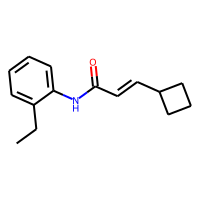
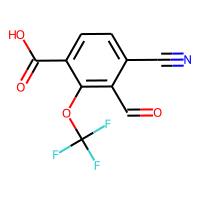
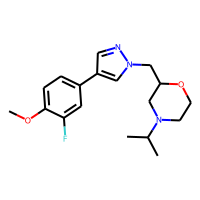
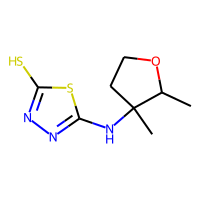
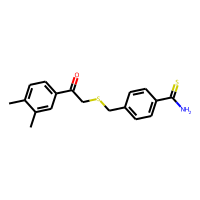

In [103]:
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

esol_data = pd.DataFrame(concatenated['isosmiles'])
PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='isosmiles')
esol_data.head()

In [104]:
from rdkit.Chem import MolFromSmiles

m = [MolFromSmiles(smiles, sanitize=False) for smiles in concatenated['isosmiles']]

**IMPORTANT!!**

If the code below is not working, you might want to select another randomized SMILES, because your previous randomly chosen SMILES couldn't be converted to Morgan fingerprint. 

In [105]:
# Now let's convert SMILES to Morgan fingerprint

radius=3
nBits=1024

ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in esol_data['ROMol']]
vector = np.array(ECFP6)

ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6]

In [106]:
from sklearn.decomposition import PCA

# Fit PCA into 2 dimensions
pca = PCA(n_components=2)
crds = pca.fit_transform(ecfp6_bits)

In [107]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
# crds_df['crystal_score'] = list(y_binary)
crds_df['data_collected'] = list(concatenated['data_collected'])
crds_df.head()

,PC_1,PC_2,data_collected
0,-1.054885,0.659318,0
1,0.185736,-0.418163,0
2,-0.858261,-0.166365,0
3,-0.012041,1.100706,0
4,-0.719739,-0.651058,0


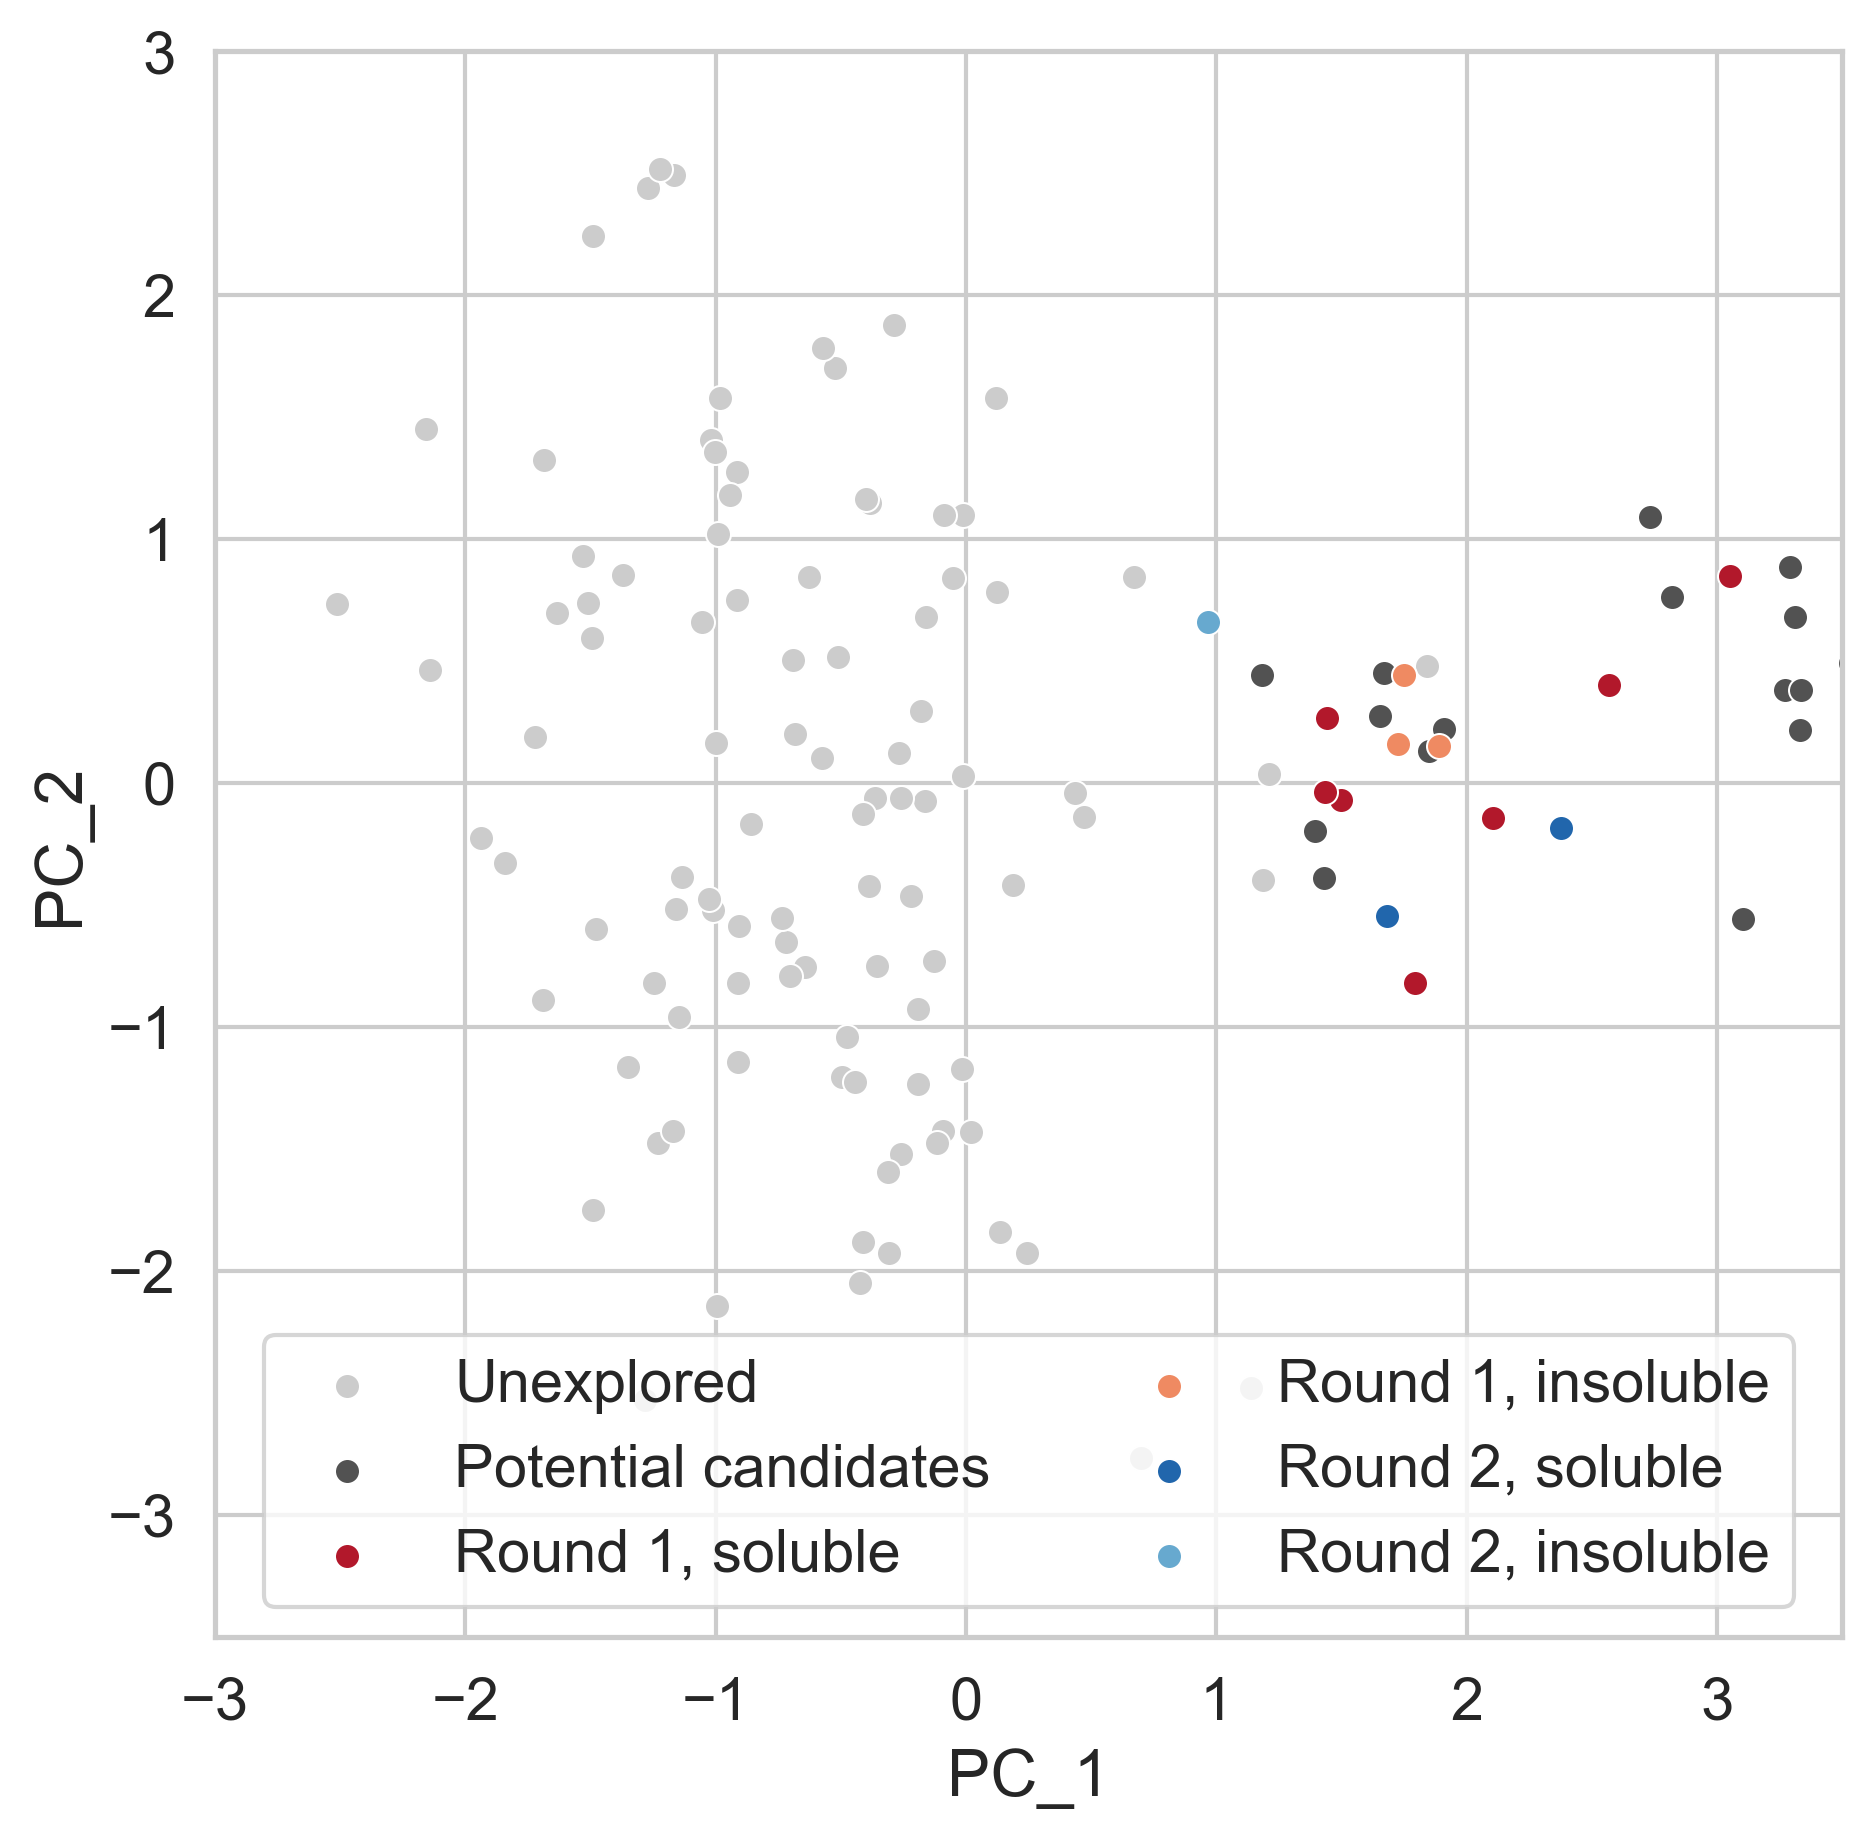

In [108]:
# Plot figure
sns.set(rc={'figure.figsize': (7,7)})
plt.rcParams['figure.dpi'] = 300

sns.set(font_scale=1.3)
sns.set_style('whitegrid')

sns.color_palette("mako", as_cmap=True)

ax = sns.scatterplot(data=crds_df.query("data_collected == 0"),x="PC_1",y="PC_2",color='#cccccc')
ax = sns.scatterplot(data=crds_df.query("data_collected == 1"),x="PC_1",y="PC_2",color='#525252')
ax = sns.scatterplot(data=crds_df.query("data_collected == 2"),x="PC_1",y="PC_2",color='#b2182b')
ax = sns.scatterplot(data=crds_df.query("data_collected == 3"),x="PC_1",y="PC_2",color='#ef8a62')
ax = sns.scatterplot(data=crds_df.query("data_collected == 4"),x="PC_1",y="PC_2",color='#2166ac')
ax = sns.scatterplot(data=crds_df.query("data_collected == 5"),x="PC_1",y="PC_2",color='#67a9cf')

ax.set_xlim([-3,3.5])
ax.set_ylim([-3.5,3])

_ = plt.legend(labels=['Unexplored','Potential candidates', 'Round 1, soluble', 'Round 1, insoluble',
                       'Round 2, soluble','Round 2, insoluble'],loc='lower center', ncol=2)

plt.show()

In [109]:
var = np.sum(pca.explained_variance_ratio_)
print(var, pca.explained_variance_ratio_) # Variance of PCA

0.07460834884766411 [0.0457771  0.02883125]


In [110]:
# Evaluate between 5-20 principal components

def evaluate_components(fp_list):
    res = []
    for n_comp in tqdm(range(2,50)):
        pca = PCA(n_components=n_comp)
        crds = pca.fit_transform(fp_list) 
        var = np.sum(pca.explained_variance_ratio_)
        res.append([n_comp,var])
    return res

In [111]:
comp_res = evaluate_components(ecfp6_bits)

100%|██████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.37it/s]


In [112]:
res_df = pd.DataFrame(comp_res,columns=["Components","Variance"])
res_df.head()

,Components,Variance
0,2,0.074609
1,3,0.098755
2,4,0.122086
3,5,0.144254
4,6,0.165268


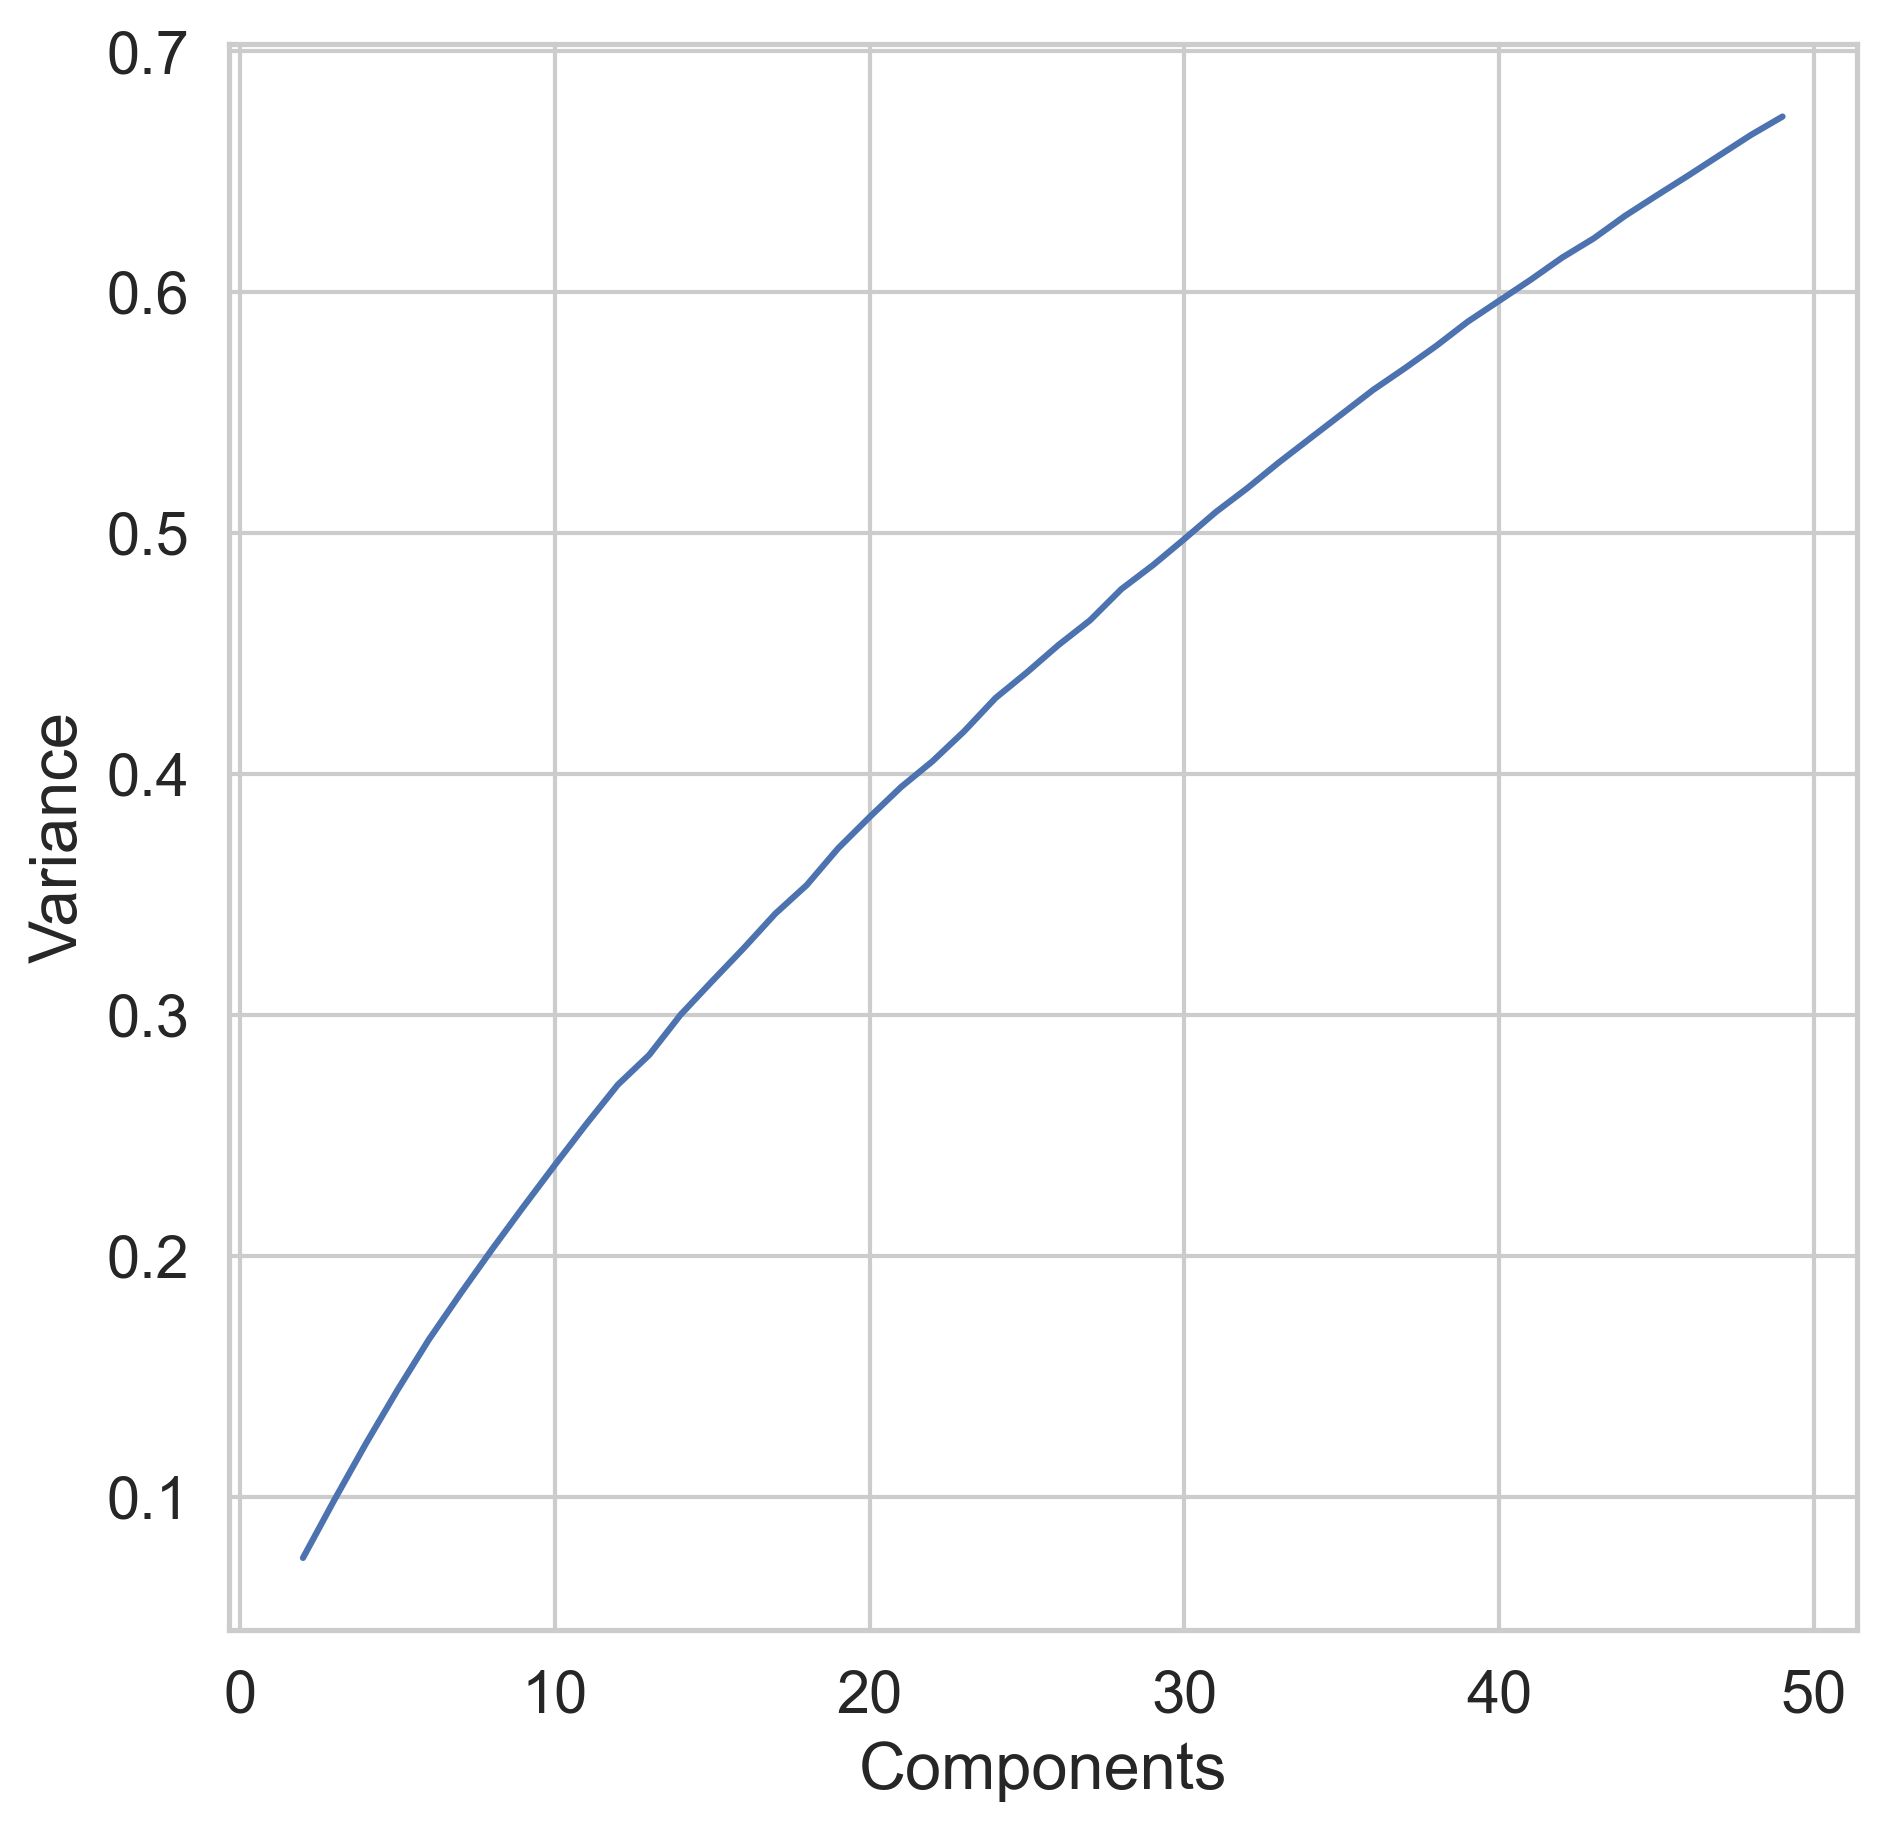

In [113]:
# Plotting PCA based on how many PCA components there are
ax = sns.lineplot(data=res_df,x="Components",y="Variance")
plt.show()

## t-SNE Analysis

In [114]:
pca = PCA(n_components=2)
crds = pca.fit_transform(ecfp6_bits)

In [115]:
from sklearn.manifold import TSNE
%time crds_embedded = TSNE(n_components=2).fit_transform(crds)

C:\Users\Titan\Anaconda3\envs\pvkadditives\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Titan\Anaconda3\envs\pvkadditives\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Wall time: 527 ms


In [116]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['data_collected'] = list(concatenated['data_collected'])

crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['data_collected'] = list(concatenated['data_collected'])
tsne_df.head()

,X,Y,data_collected
0,3.891414,-3.948198,0
1,8.637611,-6.573698,0
2,5.431508,-6.726392,0
3,6.117380,-1.848070,0
4,6.121326,-8.676664,0


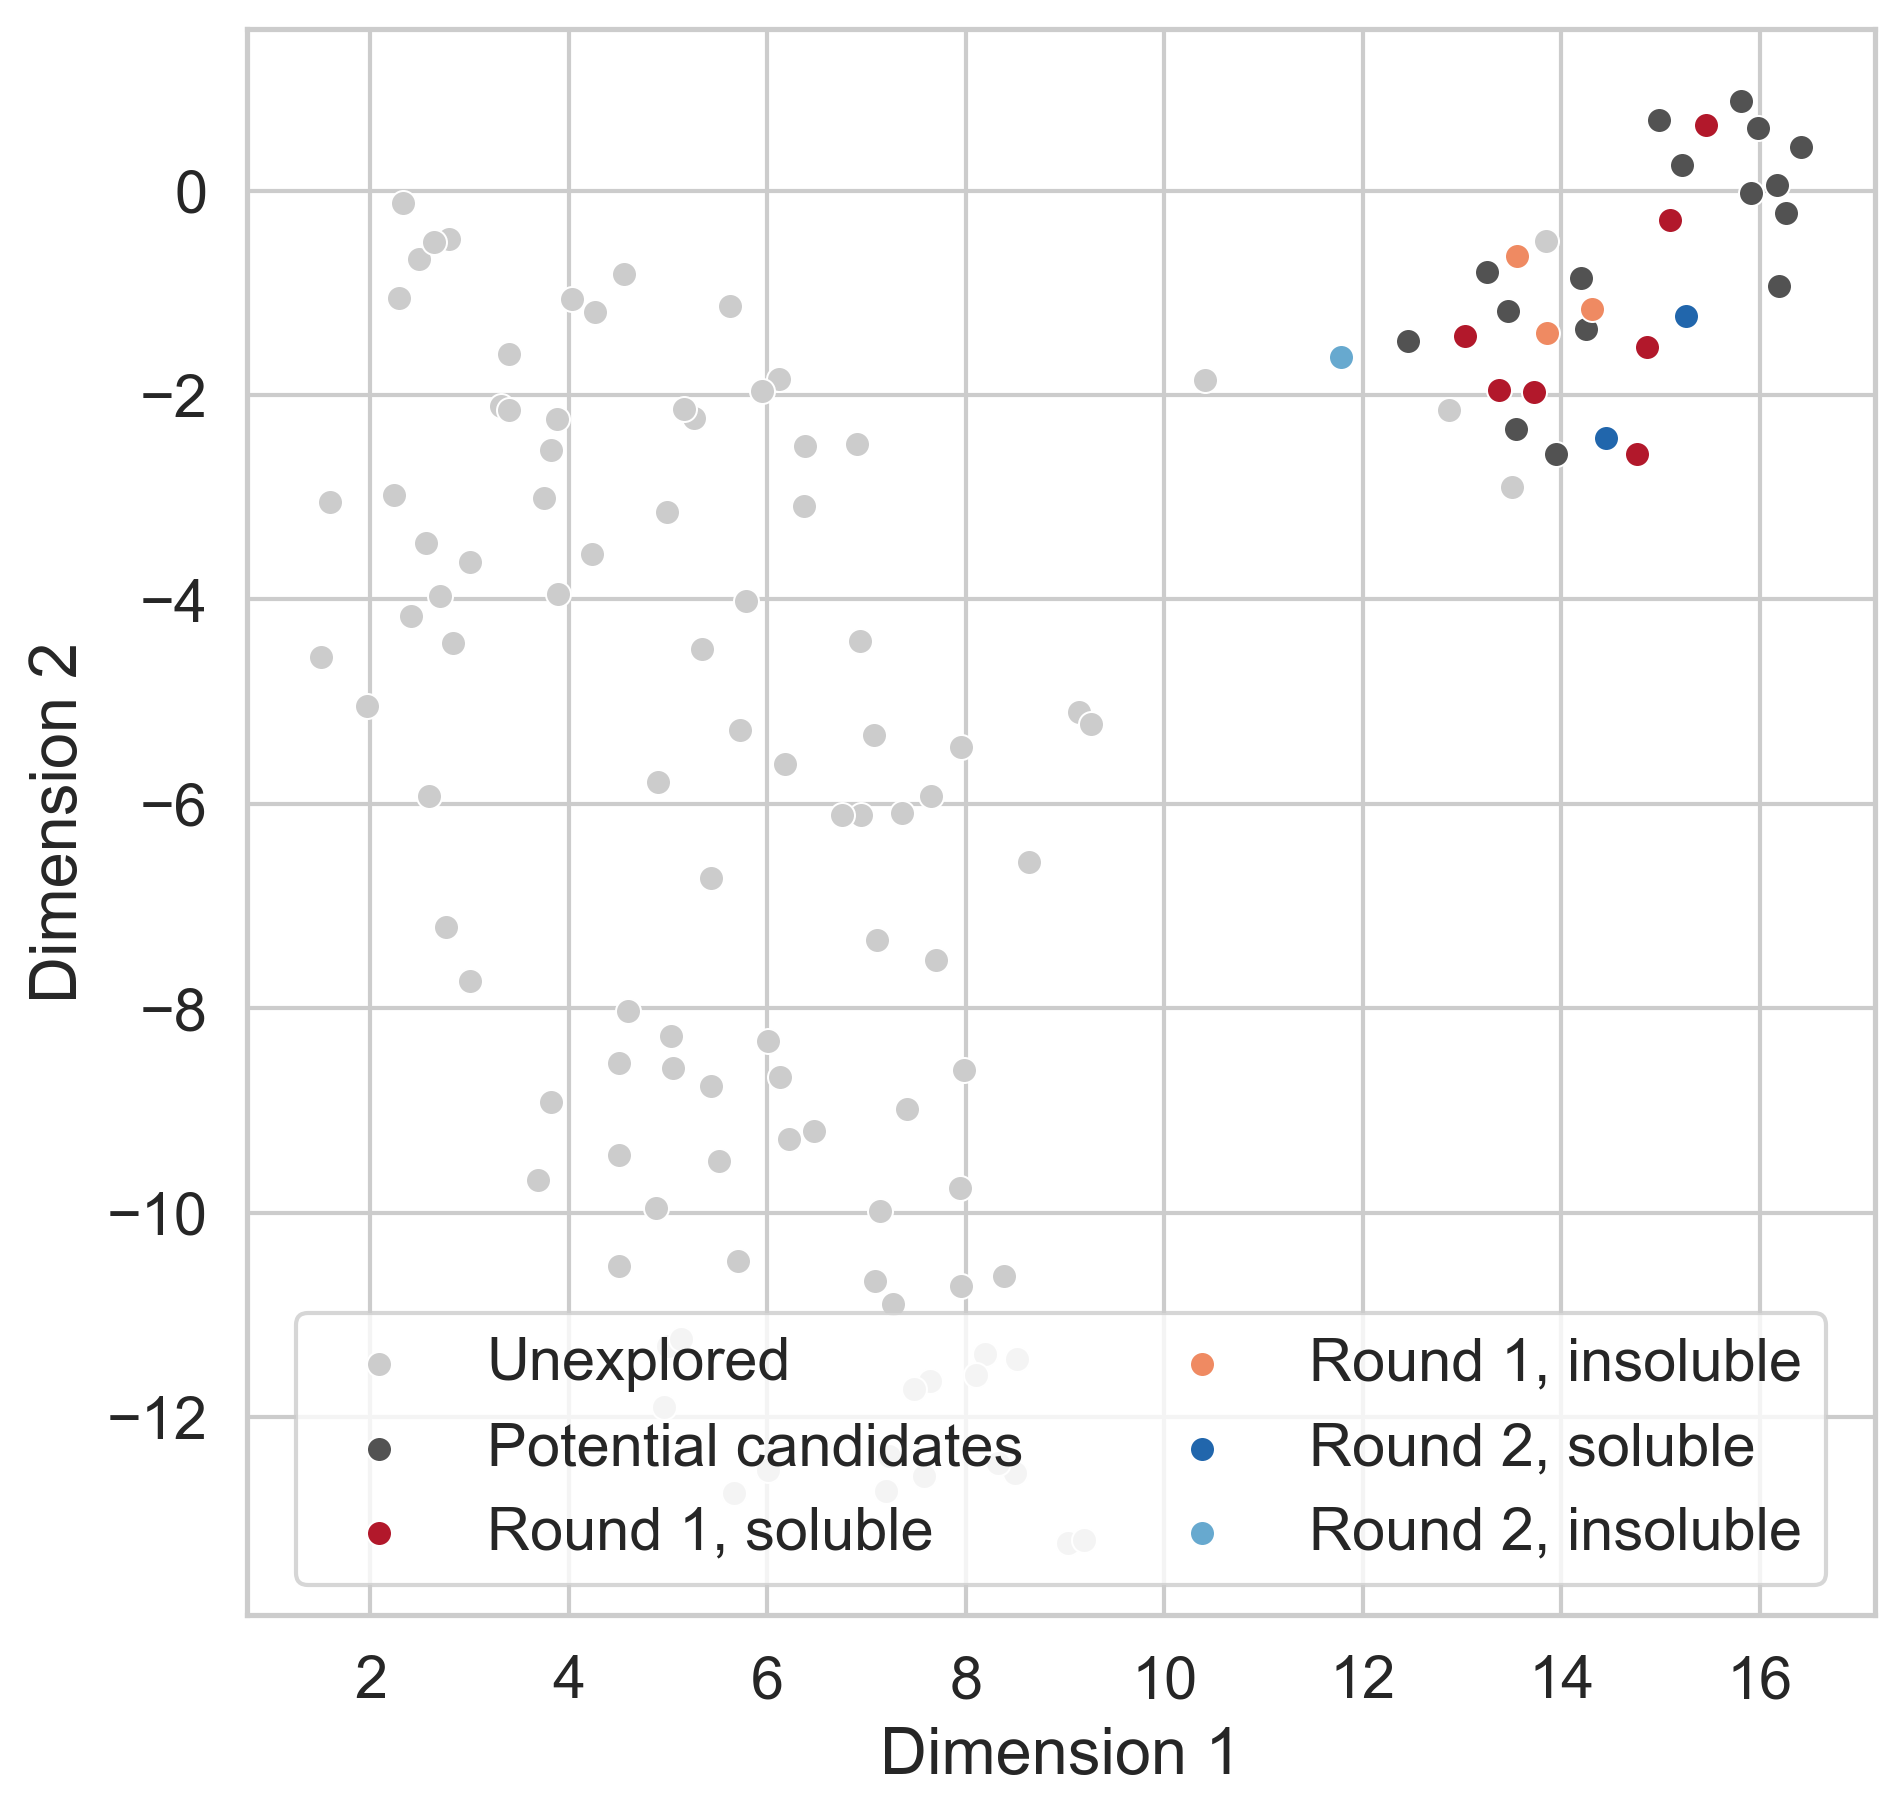

In [121]:
# Plotting the t-SNE plot
sns.set(rc={'figure.figsize': (7,7)})
plt.rcParams['figure.dpi'] = 300

sns.set(font_scale=1.3)
# sns.set_style('white')
sns.set_style('whitegrid')

# plt.ylim([-50,50])

sns.color_palette("mako", as_cmap=True)

ax = sns.scatterplot(data=tsne_df.query("data_collected == 0"),x="X",y="Y",color='#cccccc')
ax = sns.scatterplot(data=tsne_df.query("data_collected == 1"),x="X",y="Y",color='#525252')
ax = sns.scatterplot(data=tsne_df.query("data_collected == 2"),x="X",y="Y",color='#b2182b')
ax = sns.scatterplot(data=tsne_df.query("data_collected == 3"),x="X",y="Y",color='#ef8a62')
ax = sns.scatterplot(data=tsne_df.query("data_collected == 4"),x="X",y="Y",color='#2166ac')
ax = sns.scatterplot(data=tsne_df.query("data_collected == 5"),x="X",y="Y",color='#67a9cf')

_ = plt.legend(labels=['Unexplored','Potential candidates', 'Round 1, soluble', 'Round 1, insoluble',
                       'Round 2, soluble','Round 2, insoluble'], loc='lower center', ncol=2)
#               bbox_to_anchor=(1, 0.5), ncol=2)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()


## Generate box (rectangular) function

Based on the first round of experiment, ATSC5Z keeps coming up as one of the most important features. The optimum ATSC5Z value seems to be ~-31.48. So, we are going to define a range (or a 'box') around this value, and assume that if the ATSC5Z value of the molecules falls within this range, their *f(x)* = 1, otherwise *f(x)* = 0. 

This will serve as the 'output' of our dataset.

,isosmiles,ROMol
29188367,CCc1ccccc1NC(=O)\C=C\C1CCC1,
8730561,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,
21692157,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,
14954592,CC1OCCC1(C)Nc1nnc(S)s1,
...,...,...
25,CC(C)(C)c1ccnc(c1)-c2cc(ccn2)C(C)(C)C,
26,COc1ccnc(c1)-c2cc(OC)ccn2,
27,Cc1ccc(cc1)-c2cc(nc(c2)-c3ccccn3)-c4ccccn4,
28,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,

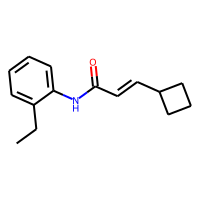
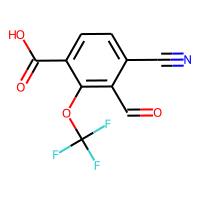
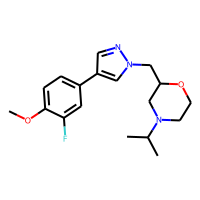
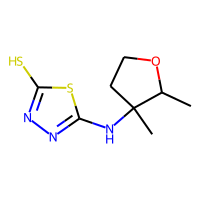
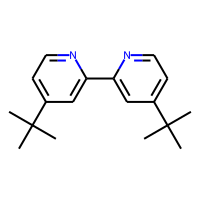
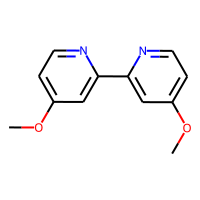
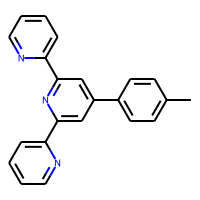
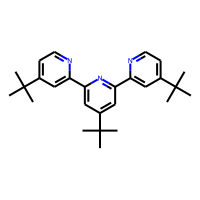

In [122]:
# First, let's convert the SMILES into molecules, then generate the Mordred descriptors.
esol_data = pd.DataFrame(concatenated['isosmiles'])
PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='isosmiles')
esol_data

In [123]:
from multiprocessing import freeze_support
from rdkit import Chem
from mordred import Calculator, descriptors
from rdkit import Chem

# Create Calculator
calc = Calculator(descriptors)

# Generate Mordred descriptors
mordred_data = calc.pandas(esol_data['ROMol'])
mordred_data = mordred_data.dropna(axis='columns')
mordred_data
mordred_data.dtypes

100%|████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:09<00:00, 13.30it/s]


ABC         float64
ABCGG       float64
nAcid         int64
nBase         int64
             ...   
Zagreb1     float64
Zagreb2     float64
mZagreb1    float64
mZagreb2    float64
Length: 1826, dtype: object

In [124]:
# Pre-process the descriptors
numeric_cols = mordred_data.select_dtypes(exclude='number')
mordred_data.drop(numeric_cols, axis=1, inplace=True)
mordred_data.dropna(axis=1,inplace=True)

# mordred_data.to_csv('20211004_mordred_largeDataset_750mols_cleaned.csv',index = False, header=True) # Save to csv if you need one
mordred_data

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
29188367,12.796872,11.289171,0,0,20.949469,2.288246,4.576491,20.949469,1.232322,3.751243,...,9.526391,49.402149,229.146664,6.365185,588,20,82.0,92.0,5.194444,3.944444
8730561,13.261697,12.678929,1,0,20.764175,2.427067,4.854134,20.764175,1.153565,3.780081,...,9.766923,50.896717,259.009242,11.773147,563,27,88.0,100.0,8.868056,4.069444
21692157,18.591625,14.779717,0,1,30.779179,2.391310,4.716011,30.779179,1.282466,4.104391,...,9.977806,71.945149,333.185255,6.941359,1508,35,124.0,144.0,7.888889,5.333333
14954592,10.922690,10.541939,0,0,17.249528,2.414919,4.694175,17.249528,1.232109,3.582110,...,9.518634,61.662662,231.050004,8.557408,298,17,74.0,86.0,5.145833,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,15.639095,13.259246,0,0,23.959451,2.404364,4.808728,23.959451,1.197973,3.918339,...,9.985206,53.910674,268.193949,6.095317,808,30,106.0,121.0,8.569444,4.111111
26,11.980375,10.246883,0,0,21.229776,2.339451,4.678903,21.229776,1.326861,3.686337,...,9.470780,47.986282,216.089878,7.717496,448,22,78.0,89.0,4.944444,3.777778
27,19.787059,14.909821,0,0,33.902863,2.423342,4.846685,33.902863,1.356115,4.160446,...,10.084850,59.767548,323.142248,7.693863,1464,38,132.0,154.0,6.027778,5.500000
28,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,4.330018,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556


In [125]:
X_combined = concatenated.join(mordred_data)
X_combined = X_combined.drop(['data_collected'],axis='columns')
X_combined = X_combined.dropna(axis='columns')
X_combined.to_csv('dataset/20211018_mordred_100mols_cleaned_withSMILES.csv',index = False, header=True) # Save dataset to csv
X_combined

,isosmiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
29188367,CCc1ccccc1NC(=O)\C=C\C1CCC1,12.796872,11.289171,0,0,20.949469,2.288246,4.576491,20.949469,1.232322,...,9.526391,49.402149,229.146664,6.365185,588,20,82.0,92.0,5.194444,3.944444
8730561,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,13.261697,12.678929,1,0,20.764175,2.427067,4.854134,20.764175,1.153565,...,9.766923,50.896717,259.009242,11.773147,563,27,88.0,100.0,8.868056,4.069444
21692157,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,18.591625,14.779717,0,1,30.779179,2.391310,4.716011,30.779179,1.282466,...,9.977806,71.945149,333.185255,6.941359,1508,35,124.0,144.0,7.888889,5.333333
14954592,CC1OCCC1(C)Nc1nnc(S)s1,10.922690,10.541939,0,0,17.249528,2.414919,4.694175,17.249528,1.232109,...,9.518634,61.662662,231.050004,8.557408,298,17,74.0,86.0,5.145833,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,CC(C)(C)c1ccnc(c1)-c2cc(ccn2)C(C)(C)C,15.639095,13.259246,0,0,23.959451,2.404364,4.808728,23.959451,1.197973,...,9.985206,53.910674,268.193949,6.095317,808,30,106.0,121.0,8.569444,4.111111
26,COc1ccnc(c1)-c2cc(OC)ccn2,11.980375,10.246883,0,0,21.229776,2.339451,4.678903,21.229776,1.326861,...,9.470780,47.986282,216.089878,7.717496,448,22,78.0,89.0,4.944444,3.777778
27,Cc1ccc(cc1)-c2cc(nc(c2)-c3ccccn3)-c4ccccn4,19.787059,14.909821,0,0,33.902863,2.423342,4.846685,33.902863,1.356115,...,10.084850,59.767548,323.142248,7.693863,1464,38,132.0,154.0,6.027778,5.500000
28,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556


### Start here if you are not randomly picking SMILES from the beginning

In [126]:
X_combined = pd.read_csv('dataset/20211018_mordred_100mols_cleaned_withSMILES.csv')
X_combined = pd.DataFrame(X_combined)

C:\Users\Titan\Anaconda3\envs\pvkadditives\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

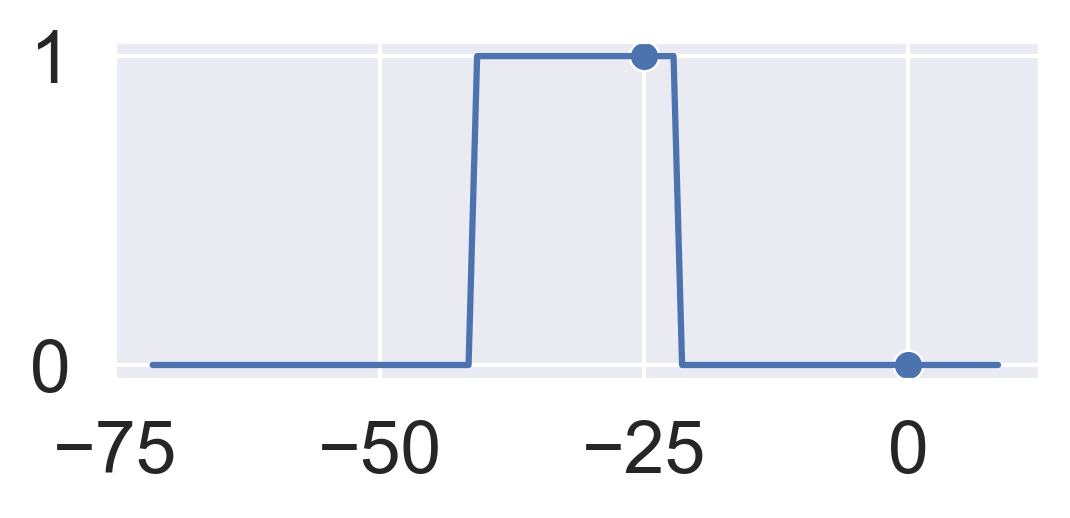

In [129]:
from numpy import linspace, sqrt, sin, exp, convolve, abs, where

n = -31.4792899408284 # ATSC5Z values of interest

# An example of the box function
def box_1(x):
    return (where(abs(x)<=10, 1, 0))

# Plotting the figure
sns.set(rc={'figure.figsize': (4,1.5)})
plt.rcParams['figure.dpi'] = 300
sns.set(font_scale=1.6)
sns.set_style('darkgrid')

x = linspace(-40,40, 100)
x_1 = np.array([0,-25])
y_1 = np.array([0,1])

plt.plot(x+n,box_1(x))
sns.scatterplot(x_1,y_1,s=50)

,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7,box_8,box_9,...,box_15,box_16,box_17,box_18,box_19,box_20,box_21,box_22,box_23,box_24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


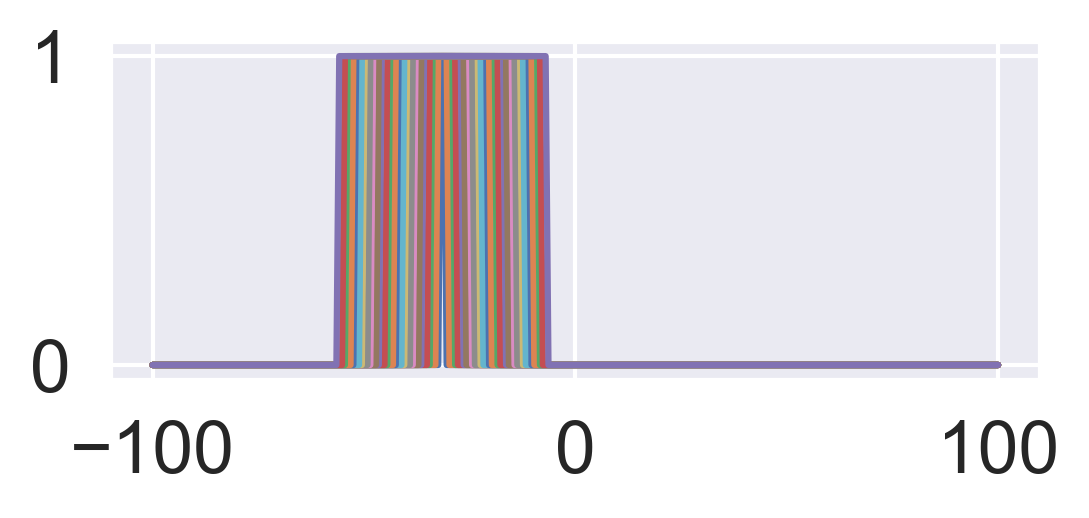

In [130]:
# Generate different f(x) values based on the 'width' of the box
result = pd.DataFrame()

for k in range(25):
    box_width = k+0.5 # Define different widths
    x = np.linspace(-100,100, 300)
    plt.plot(x,np.where(abs(x-n)<=box_width, 1, 0))
    result['box_'+str(k)]=(where(abs(X_combined['ATSC5Z']-n)<=box_width, 1, 0)) # Box function
    
result

In [131]:
result.to_csv('dataset/20211019_mordred_100mols_box_0_25.csv',index = False, header=True) # Save to csv

Let's start building the dataset (*f(x)* with box function), assuming one important features: ATSC5Z.

In [133]:
data_all = pd.read_csv('dataset/20211018_mordred_100mols_cleaned_withSMILES.csv')
result = pd.read_csv('dataset/20211019_mordred_100mols_box_0_25.csv')
data_all = pd.DataFrame(data_all)
result = pd.DataFrame(result)
data_all

,isosmiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCc1ccccc1NC(=O)\C=C\C1CCC1,12.796872,11.289171,0,0,20.949469,2.288246,4.576491,20.949469,1.232322,...,9.526391,49.402149,229.146664,6.365185,588,20,82.0,92.0,5.194444,3.944444
1,OC(=O)c1ccc(C#N)c(C=O)c1OC(F)(F)F,13.261697,12.678929,1,0,20.764175,2.427067,4.854134,20.764175,1.153565,...,9.766923,50.896717,259.009242,11.773147,563,27,88.0,100.0,8.868056,4.069444
2,COc1ccc(cc1F)-c1cnn(CC2CN(CCO2)C(C)C)c1,18.591625,14.779717,0,1,30.779179,2.391310,4.716011,30.779179,1.282466,...,9.977806,71.945149,333.185255,6.941359,1508,35,124.0,144.0,7.888889,5.333333
3,CC1OCCC1(C)Nc1nnc(S)s1,10.922690,10.541939,0,0,17.249528,2.414919,4.694175,17.249528,1.232109,...,9.518634,61.662662,231.050004,8.557408,298,17,74.0,86.0,5.145833,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,CC(C)(C)c1ccnc(c1)-c2cc(ccn2)C(C)(C)C,15.639095,13.259246,0,0,23.959451,2.404364,4.808728,23.959451,1.197973,...,9.985206,53.910674,268.193949,6.095317,808,30,106.0,121.0,8.569444,4.111111
126,COc1ccnc(c1)-c2cc(OC)ccn2,11.980375,10.246883,0,0,21.229776,2.339451,4.678903,21.229776,1.326861,...,9.470780,47.986282,216.089878,7.717496,448,22,78.0,89.0,4.944444,3.777778
127,Cc1ccc(cc1)-c2cc(nc(c2)-c3ccccn3)-c4ccccn4,19.787059,14.909821,0,0,33.902863,2.423342,4.846685,33.902863,1.356115,...,10.084850,59.767548,323.142248,7.693863,1464,38,132.0,154.0,6.027778,5.500000
128,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556


## RFE + random forest classification + Shapley value analysis

Now, we have the dataset ready to perform the sequence of algorithms to simulate the actual dataset for hypothesis generation round.

### RFE/ recursive feature elimination

In [134]:
# Explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [135]:
# Now, we pick the specific f(x)
y_binary = result['box_20'] # Choosing box 5 (width of ATSC5Z value = 41)
X_combined = data_all.drop(['isosmiles'],axis=1)
y_binary

0      0
1      0
2      0
3      0
      ..
125    0
126    0
127    0
128    0
Name: box_20, Length: 129, dtype: int64

In [136]:
# Dropping anything with high correlation (> 0.95)
cor_matrix = X_combined.corr().abs() 
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if (any(upper_tri[column] > 0.95)|any(upper_tri[column] ==float('nan')))]
X_all_pre_noCorr = X_combined.drop(to_drop, axis=1)
X_all_pre_noCorr

C:\Users\Titan\AppData\Local\Temp/ipykernel_18072/2787145917.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


,ABC,nAcid,nBase,SpMax_A,SpDiam_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nAtom,...,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05,TSRW10,mZagreb1
0,12.796872,0,0,2.288246,4.576491,1.232322,3.790769,86.702821,6,36,...,0.015447,0.010937,0.004132,0.006875,0.006173,0.384612,1.000000,0.000000,49.402149,5.194444
1,13.261697,1,0,2.427067,4.854134,1.153565,3.713320,88.709189,6,22,...,0.015432,0.000000,0.000000,0.000000,0.000000,0.589788,0.750000,0.000000,50.896717,8.868056
2,18.591625,0,1,2.391310,4.716011,1.282466,4.307027,181.121096,11,48,...,0.020907,0.010220,0.011432,0.010156,0.007156,0.455115,1.000000,2.397895,71.945149,7.888889
3,10.922690,0,0,2.414919,4.694175,1.232109,3.415180,65.297352,5,27,...,0.019778,0.013605,0.000000,0.000000,0.000000,0.583201,0.750000,3.044522,61.662662,5.145833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,15.639095,0,0,2.404364,4.808728,1.197973,4.171020,96.083000,12,44,...,0.020408,0.019965,0.028723,0.000000,0.000000,0.636527,0.800000,0.000000,53.910674,8.569444
126,11.980375,0,0,2.339451,4.678903,1.326861,3.672898,80.644159,12,28,...,0.013605,0.014757,0.016377,0.000000,0.000000,0.380841,0.800000,0.000000,47.986282,4.944444
127,19.787059,0,0,2.423342,4.846685,1.356115,4.414207,192.028726,24,42,...,0.011729,0.003323,0.007997,0.009219,0.007084,0.325430,0.833333,0.000000,59.767548,6.027778
128,23.791976,0,0,2.457256,4.914512,1.204310,4.891280,204.554042,18,65,...,0.016224,0.018939,0.023648,0.005263,0.010853,0.644299,1.000000,0.000000,66.167879,12.715278


>2 0.977 (0.060)
>4 0.967 (0.059)
>6 0.946 (0.075)


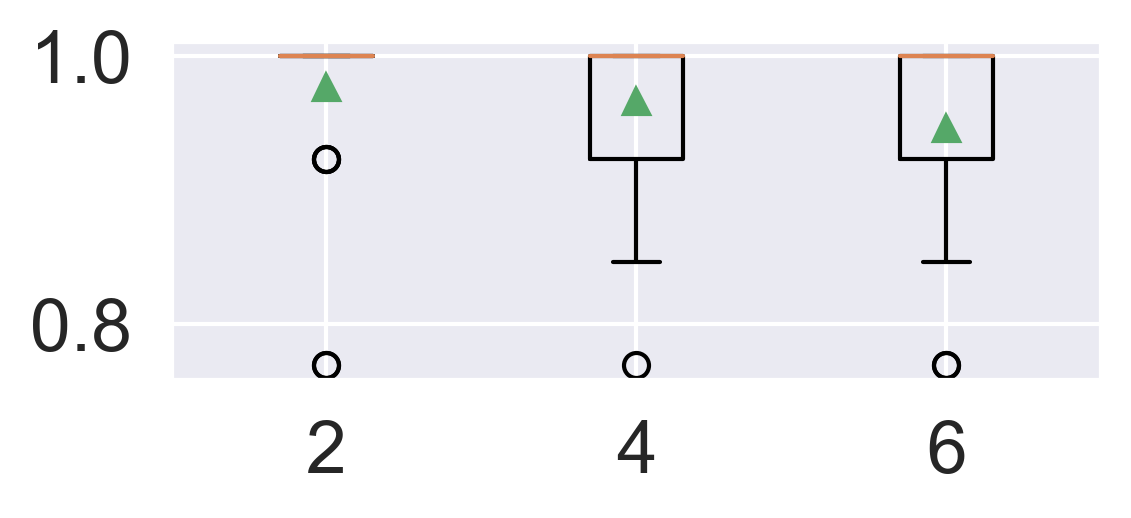

In [137]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2,7,2):
#         rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=i)
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i) # Because we're doing classification
        model = RandomForestClassifier()
#         model = RandomForestRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# Evaluate any given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # For classification
#     cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # For regression
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') # For classification
#     scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise') # For regression
   
    return scores

# Get the models to evaluate
models = get_models()

# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_all_pre_noCorr, y_binary)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# Plot model performance for comparison
sns.set_style('white')
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

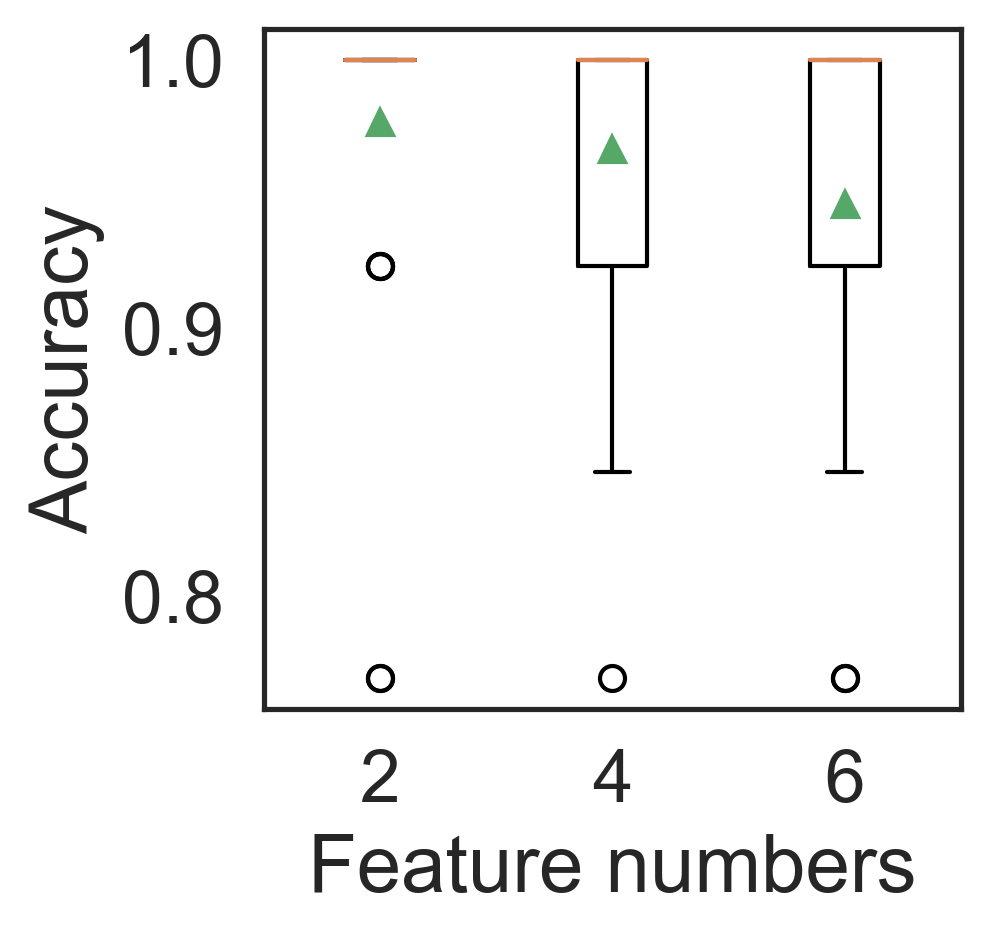

In [141]:
# Edit the plot so that it looks good
plt.figure(figsize=(3,3))
sns.set_style('white')
plt.boxplot(results, labels=names, showmeans=True)
font = {'family' : 'Arial',
#         'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Feature numbers')
plt.ylabel('Accuracy')
plt.show()

In [142]:
# Generating the dataframe with different feature numbers results
featureNum = [2,4,6]
resultDF = pd.DataFrame(results)
resultDF['featureNum'] = featureNum

# Rearranging columns
cols = resultDF.columns.tolist()
cols = cols[-1:] + cols[:-1]
resultDF = resultDF[cols]

# saving results as csv
resultDF.to_csv('dataset/20211019_corrDrop_feature2to6_100mols_box_20.csv',index=False)

resultDF

,featureNum,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,2,1.0,1.0,0.923077,1.0,1.0,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,0.769231,1.000000,1.000000,0.923077,0.769231,1.0,0.923077,1.0
1,4,1.0,1.0,0.923077,1.0,1.0,0.923077,0.923077,1.000000,1.000000,...,1.0,1.0,0.769231,0.923077,0.923077,0.846154,1.000000,1.0,1.000000,1.0
2,6,1.0,1.0,0.846154,1.0,1.0,0.923077,1.000000,0.923077,0.846154,...,1.0,1.0,0.769231,0.923077,0.923077,0.846154,1.000000,1.0,0.846154,1.0


In [143]:
# Let's pick a certain number of features and see how it performs
n = 6

# Now, we go through RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n)
model = RandomForestClassifier()
pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])

# We also do cross-validation
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1) # For regression
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=2)

# Now, we look at the cross-validation score
# n_scores = cross_val_score(pipe, X_all_pre_noCorr, y_binary, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1) # For regression
n_scores = cross_val_score(pipe, X_all_pre_noCorr, y_binary, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9412820512820512

In [144]:
pipe.fit(X_all_pre_noCorr, y_binary) # Fitting to the pipeline

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=6)),
                ('Model', RandomForestClassifier())])

In [145]:
# Check which one is used and which one is dropped
pd.set_option('display.max_rows', None)
(pd.DataFrame(rfe.support_,index=X_all_pre_noCorr.columns,columns=['Rank']))#.head(20)

,Rank
ABC,False
nAcid,False
nBase,False
SpMax_A,False
SpDiam_A,False
SpMAD_A,False
VE1_A,False
VR1_A,False
nAromAtom,False
nAtom,False


### Supervised learning: random forest classification

After we select the features and eliminate the rest of them, now we can start doing the supervised learning: random forest classification.

In [146]:
# Selected features
X_all_pre_noCorr_RFE = X_all_pre_noCorr.loc[:, rfe.support_]
X_all_pre_noCorr_RFE

,ATSC5Z,ATSC1v,ATSC0p,AATSC5Z,MATS5Z,MATS6Z
0,8.333333,60.418894,8.527989,0.115741,0.017015,-0.158802
1,-7.190083,29.213274,5.179722,-0.167211,-0.025578,-0.026549
2,110.861111,-141.223429,10.790778,0.815155,0.106349,0.082492
3,150.799726,-38.275105,11.423459,2.356246,0.134574,-0.425016
4,39.936347,155.922623,15.289524,0.434091,0.032151,0.047790
5,-94.000000,9.702468,15.057702,-0.614379,-0.059670,-0.104978
6,152.299169,-22.903935,21.124330,0.742923,0.037649,0.007831
7,99.921795,-42.874421,16.900614,0.640524,0.065785,-0.009539
8,311.669095,6.925891,16.856218,2.454087,0.250731,-0.364921
9,113.839677,-37.114984,11.481487,0.824925,0.110157,0.135835


In [147]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all_pre_noCorr_RFE, y_binary, test_size=0.2, random_state=1) # Test set is 20% of the total data, and the random state is set to ensure identical results for each run

print("X_train's shape is", X_train.shape,"; y_train's shape is", y_train.shape)
print("X_test's shape is", X_test.shape,"; y_test's shape is", y_test.shape)

X_train's shape is (103, 6) ; y_train's shape is (103,)
X_test's shape is (26, 6) ; y_test's shape is (26,)


In [148]:
# Because we're doing random forest, we are not standardizing the train and test set
X_train_stand = X_train
X_test_stand = X_test

In [149]:
# Random Forest, choosing best parameters using GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
    
# Perform Grid-Search to find optimum parameter
    gsc = GridSearchCV(
#         estimator=RandomForestRegressor(),
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(1,20),
            'n_estimators': (1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
#         scoring= 'neg_mean_squared_error', # for regression
        scoring= 'accuracy',
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
#     rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
#                                 random_state=False, verbose=False) # for regression
    rfr = RandomForestClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
                                random_state=False, verbose=False)
    
# Perform K-Fold CV
#     scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')#'neg_mean_absolute_error')
    scores = cross_val_score(rfr, X, y, cv=10, scoring='accuracy')#'neg_mean_absolute_error')

    return best_params

print('The best parameters: ',rfr_model(X_train,y_train))

The best parameters:  {'max_depth': 4, 'n_estimators': 20}


Change the random forest classifier parameter.

In [150]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

# rf_regressor = RandomForestRegressor(n_estimators=10,
#                                      max_depth =7,
#                                      random_state=1) # For regression

# Now change this based on the best parameters above
rf_classifier = RandomForestClassifier(max_depth = 4, n_estimators = 20,
                                       random_state=1)

# Fit to the training set
rf_classifier.fit(X_train_stand, y_train)

# Perform predictions on both training and test sets
y_train_hat = rf_classifier.predict(X_train_stand)
y_test_hat = rf_classifier.predict(X_test_stand)
y_all_hat = rf_classifier.predict(X_all_pre_noCorr_RFE)

# Visualize the results for regression
# prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat) # this one is for regression
# rf_regressor.feature_importances_

# Visualize confusion matrix for classification
cf_matrix = confusion_matrix(y_binary, y_all_hat)
print(cf_matrix)

[[112   0]
 [  1  16]]


In [151]:
# View accuracy score

accuracy_score(y_binary, y_all_hat)
# mean_squared_error(y_binary, y_all_hat) # For regression

0.9922480620155039

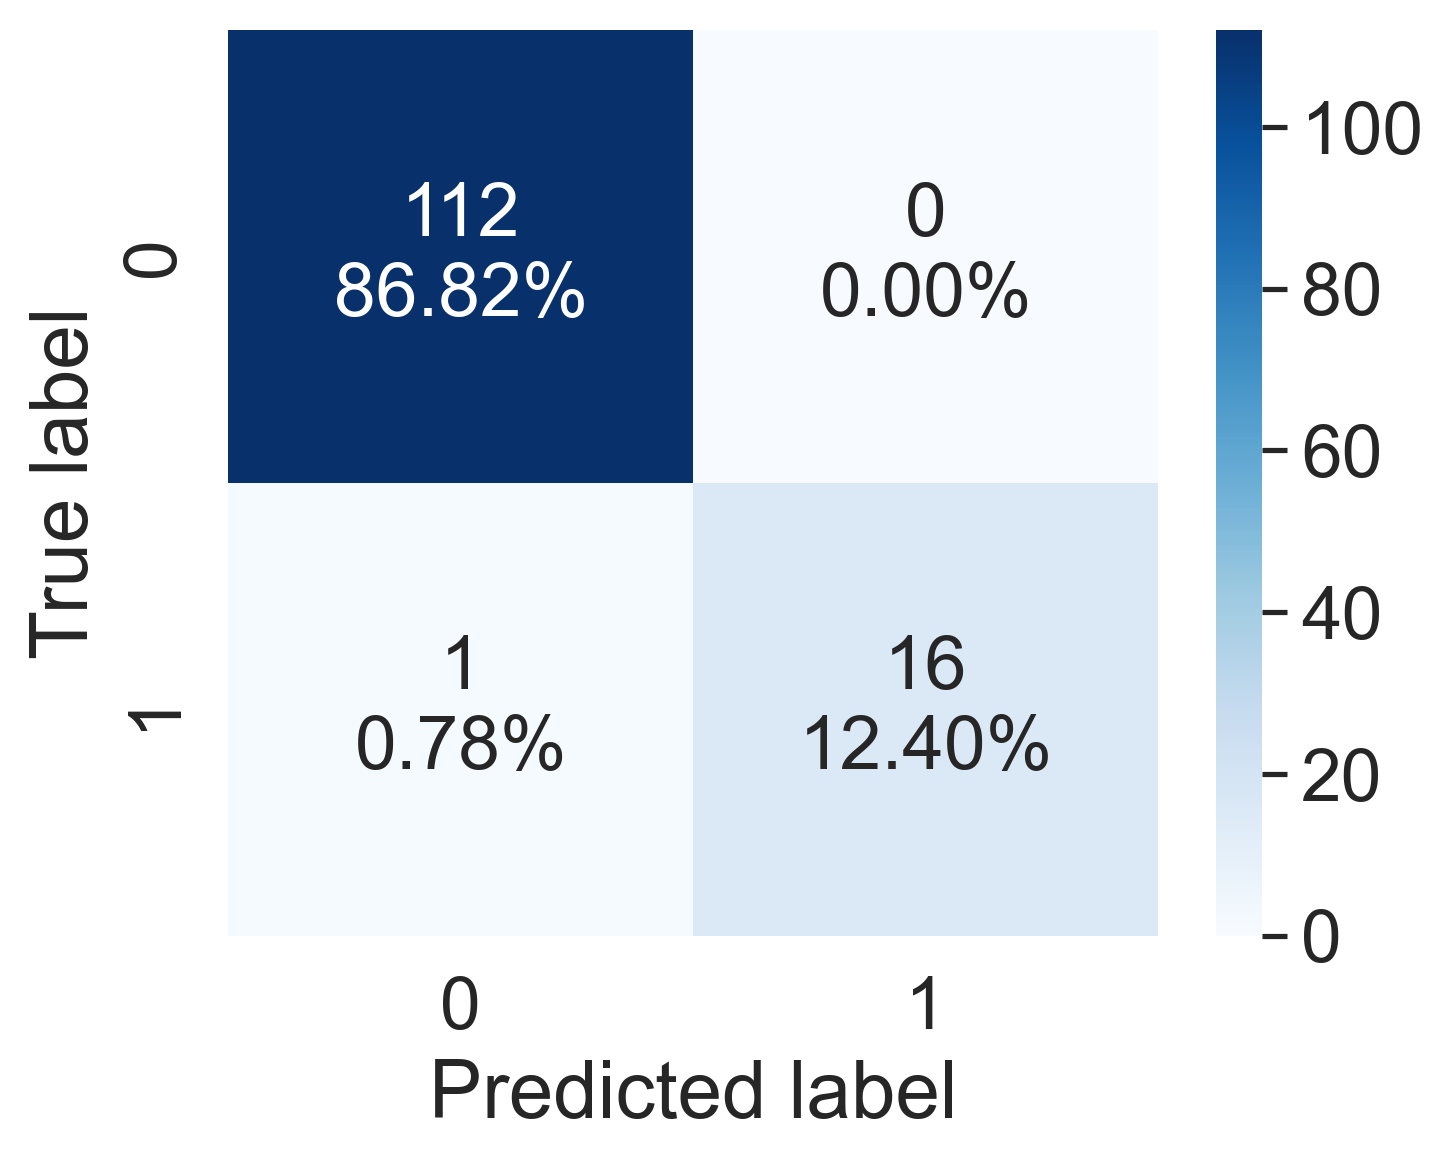

In [161]:
# Visualize the result
import seaborn as sns

# For non-binary classification:

# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(3,3)
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
# # plt.xticks([1,3,4])
# # plt.yticks([1,3,4])
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()

# For binary classification

plt.figure(figsize=(5,4))
plt.rcParams['figure.dpi'] = 300

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues') # Plotting confusion matrix
plt.xlabel('Predicted label')
plt.ylabel('True label')

font = {'family' : 'Arial',
#         'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

### Shapley value analysis

Now, we can do the feature importance rank using Shapley value analysis (https://github.com/slundberg/shap).

In [162]:
import shap

# Use shap to explain our rf_classifier
# explainerRF = shap.TreeExplainer(rf_regressor,check_additivity=False) # For regression
explainerRF = shap.TreeExplainer(rf_classifier,check_additivity=False)

# Get standardized X Dataframe
X_stand_df = X_all_pre_noCorr_RFE
shap_values_RF_test = explainerRF.shap_values(X_all_pre_noCorr_RFE)

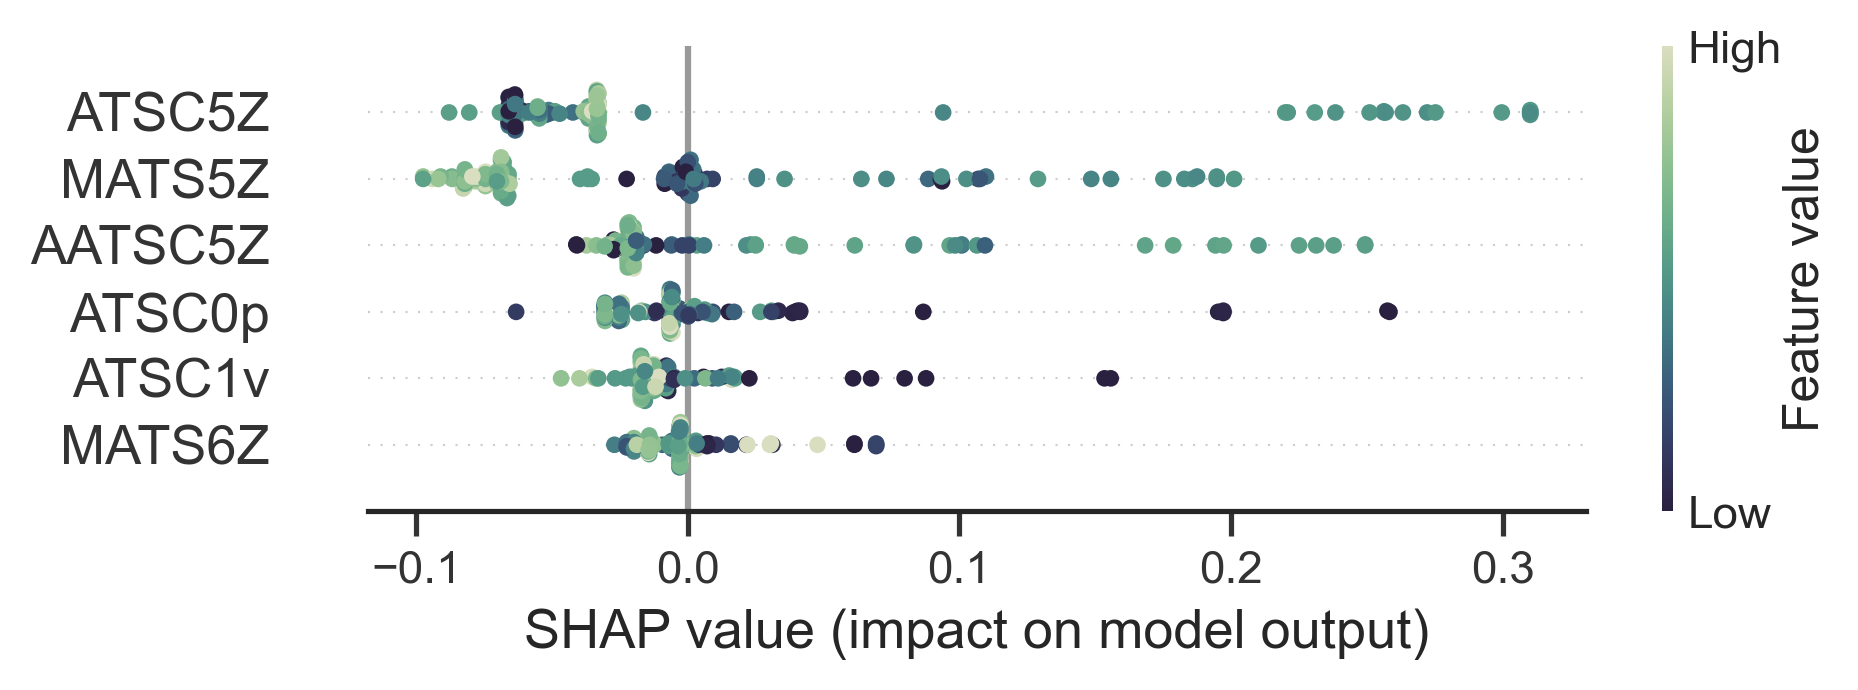

In [163]:
# Plot SHAP figure
plt.figure()
shap.summary_plot(shap_values_RF_test[1], X_stand_df,plot_type = "dot",
                            #color=plt.get_cmap("plasma"),
                           show = False) # shap_values_RF_test[1] because we care about the one that works
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'font.size': 60})
plt.rcParams['figure.dpi'] = 300

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
my_cmap = plt.get_cmap('viridis')
cmap = sns.cubehelix_palette(start=.45, rot=-.75, reverse=True, as_cmap=True)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)

# plt.show()
plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
# plt.savefig('20200505_rf_nonstand_shap.png', dpi = 1200)

Based on this, we can evaluate if our feature of interest, ATSC5Z appears as one of important features or not & survives the RFE.